In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [3]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


In [4]:
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    resaved_file_name = 'resaved_image.jpg'    
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    ela_image = ImageChops.difference(original_image,resaved_image)
    
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 255 / max_difference
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [5]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0        

In [6]:
X = []
Y = []

In [7]:

path = 'D:/CASIA2/Au/'      
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
        try:
            full_path = os.path.join(path, filename)
            X.append(prepare_image(full_path))        
            Y.append(1)     
        except:
            pass

print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/7492 [00:00<?, ?it/s]

Total images: 7354
Total labels: 7354


In [8]:
path = 'D:/CASIA2/Tp/'      
i=0
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
            i+=1
            try:
                full_path = os.path.join(path, filename)
                X.append(prepare_image(full_path))        
                Y.append(0)    
            except:
                pass

   
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/5124 [00:00<?, ?it/s]

Total images: 9418
Total labels: 9418


In [9]:
from sklearn.utils import shuffle
X = np.array(X)
Y = np.array(Y)
X,Y= shuffle(X,Y)

X = X.reshape(-1, 128, 128, 3)



np.save('proposed_fidac_500_x.npy', X, allow_pickle=True)
np.save('proposed_fidac_500_y.npy', Y, allow_pickle=True)


In [10]:
X = np.load('./proposed_fidac_500_x.npy', allow_pickle=True)
Y = np.load('./proposed_fidac_500_y.npy', allow_pickle=True)

print(np.shape(X),np.shape(Y))

(9418, 128, 128, 3) (9418,)


In [11]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 7157 , Training labels: 7157
Validation images: 1790 , Validation labels: 1790
Test images: 471 , Test labels: 471


In [12]:
train_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    #zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)
test_gen =  ImageDataGenerator()

train_gen.fit(X_train)
test_gen.fit(X_val)

augmented_data = []


In [13]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(256, (3,3), activation = 'relu'))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding = "SAME"))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [14]:
model = build_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)      

In [15]:
epochs = 50
batch_size = 19

In [16]:
init_lr = 1e-4  
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 7,
                               verbose = 0,
                               mode = 'auto')

In [18]:
hist = model.fit(train_gen.flow(X_train, Y_train, batch_size=19),
                 batch_size = batch_size,
                 epochs = epochs,
                 #steps_per_epoch = 14,
                 validation_data = train_gen.flow(X_train, Y_train, batch_size=19),
                 callbacks = [early_stopping])

Epoch 1/50


377/377 [==============================] - 112s 287ms/step - loss: 0.3660 - accuracy: 0.8186 - val_loss: 0.2803 - val_accuracy: 0.8702
Epoch 2/50
377/377 [==============================] - 100s 265ms/step - loss: 0.2930 - accuracy: 0.8710 - val_loss: 0.2689 - val_accuracy: 0.8754
Epoch 3/50
377/377 [==============================] - 104s 275ms/step - loss: 0.2843 - accuracy: 0.8744 - val_loss: 0.2558 - val_accuracy: 0.8819
Epoch 4/50
377/377 [==============================] - 103s 273ms/step - loss: 0.2747 - accuracy: 0.8776 - val_loss: 0.2575 - val_accuracy: 0.8794
Epoch 5/50
377/377 [==============================] - 102s 271ms/step - loss: 0.2671 - accuracy: 0.8787 - val_loss: 0.2483 - val_accuracy: 0.8874
Epoch 6/50
377/377 [==============================] - 101s 268ms/step - loss: 0.2683 - accuracy: 0.8843 - val_loss: 0.2372 - val_accuracy: 0.8966
Epoch 7/50
377/377 [==============================] - 104s 275ms/step - loss: 0.2524 - accuracy: 0.8939 - val_loss: 0.2306

In [19]:
model.save('ela_casia.h5') 

history_dict = hist.history
json.dump(history_dict, open('model_history', 'w'))

c:\Users\LENOVO\.virtualenvs\WebApp-a5TW4Hkh\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


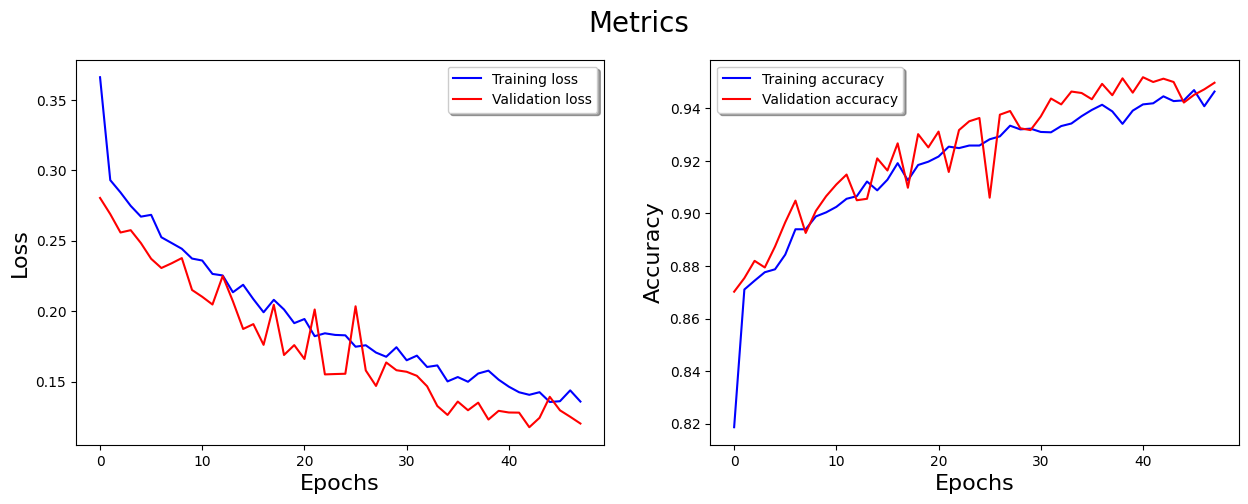

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss")
ax[0].set_xlabel('Epochs',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20);

In [22]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

56/56 [==============================] - 5s 79ms/step


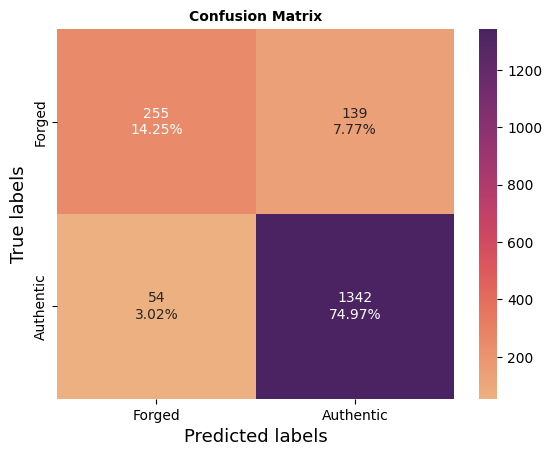

In [23]:
Y_pred = model.predict(X_val)              
Y_pred_classes = np.round(Y_pred)           
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     
plot_confusion_matrix(confusion_mtx)                         

In [24]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       394
           1       0.91      0.96      0.93      1396

    accuracy                           0.89      1790
   macro avg       0.87      0.80      0.83      1790
weighted avg       0.89      0.89      0.89      1790



In [25]:
class_names = ['Forged', 'Authentic']

In [26]:
correct_test = 0
total_test = 0  

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: 
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/471 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step
Total test images: 471
Correctly predicted images: 435
Accuracy: 92.35668789808918 %


In [11]:
#model=load_model('C:/Users/LENOVO/OneDrive/Desktop/FAKEYE/AI/ela_casia.h5')
model=load_model('C:/Users/LENOVO/Downloads/proposed_ela_50_casia_fidac (1).h5')

class_names = ['Forged', 'Authentic']
test_image = prepare_image("D:\\FIDAC_1.0\\Tampered_Images\\FIDAC_Tp_30.jpg")  
test_image=test_image.reshape(-1, 128, 128, 3)
y_pred = model.predict(test_image)
y_pred_class = int(round(y_pred[0][0]))

if y_pred <= 0.5:
    confidence = f'{(1-(y_pred[0][0])) * 100:0.2f}'
else:
    confidence = f'{(y_pred[0][0]) * 100:0.2f}'
        
print(class_names[y_pred_class],confidence)

ValueError: in user code:

    File "c:\Users\LENOVO\.virtualenvs\WebApp-a5TW4Hkh\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\LENOVO\.virtualenvs\WebApp-a5TW4Hkh\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\LENOVO\.virtualenvs\WebApp-a5TW4Hkh\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\LENOVO\.virtualenvs\WebApp-a5TW4Hkh\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\LENOVO\.virtualenvs\WebApp-a5TW4Hkh\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\LENOVO\.virtualenvs\WebApp-a5TW4Hkh\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 256, 256, 1), found shape=(None, 128, 128, 3)


In [10]:
test_folder_path = 'D:/FIDAC_1.0/Tampered_Images/'        #dataset path
authentic,forged,total = 0,0,0

for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
     print(filename)
     if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg') or filename.endswith('JPG'):
         test_image_path = os.path.join(test_folder_path, filename)
         test_image = prepare_image(test_image_path)  
         test_image=test_image.reshape(-1, 128, 128, 3)
        
         y_pred = model.predict(test_image)
         y_pred_class = round(y_pred[0][0])

         total += 1
         print('---',y_pred_class)
         if y_pred_class == 0:
             forged += 1
         else:
             authentic +=1

print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Processing Images :   0%|          | 0/597 [00:00<?, ?it/s]

FIDAC_Tp_0.jpg
1/1 [==============================] - 0s 64ms/step
--- 1
FIDAC_Tp_1.jpg
1/1 [==============================] - 0s 54ms/step
--- 1
FIDAC_Tp_10.jpg
1/1 [==============================] - 0s 55ms/step
--- 0
FIDAC_Tp_100.jpg
1/1 [==============================] - 0s 57ms/step
--- 1
FIDAC_Tp_101.jpg
1/1 [==============================] - 0s 55ms/step
--- 0
FIDAC_Tp_102.jpg
1/1 [==============================] - 0s 50ms/step
--- 1
FIDAC_Tp_103.jpg
1/1 [==============================] - 0s 56ms/step
--- 1
FIDAC_Tp_104.jpg
1/1 [==============================] - 0s 51ms/step
--- 0
FIDAC_Tp_105.jpg
1/1 [==============================] - 0s 53ms/step
--- 1
FIDAC_Tp_106.jpg
1/1 [==============================] - 0s 55ms/step
--- 1
FIDAC_Tp_107.jpg
1/1 [==============================] - 0s 58ms/step
--- 1
FIDAC_Tp_108.jpg
1/1 [==============================] - 0s 50ms/step
--- 1
FIDAC_Tp_109.jpg
1/1 [==============================] - 0s 50ms/step
--- 1
FIDAC_Tp_11.jpg
1/1 [=========